# Titanic - Machine Learning from Disaster

In [163]:
# importing important libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import liftChart, gainsChart
from sklearn.metrics import r2_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score
%matplotlib inline

In [164]:
import pandas as pd
df_train = pd.read_csv('train.csv')
print(df_train.shape)
df_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Preprocessing

In [165]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [166]:
# Defining the attribute Survived as categorical variable since we are doing Supervised learning: classification (output is categorical)
df_train['Survived'] = df_train['Survived'].astype('category')

# Dummy code the variable sex.
df_train['Sex'] = pd.get_dummies(df_train['Sex'], prefix_sep='_', drop_first=True)

In [167]:
# Checking number of missing values for each attribute

for i in df_train.columns:
    print(i, df_train[i].isnull().sum()) 

PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2


In [168]:
# filling the missing ages with mean ages
df_train['Age'].fillna((df_train['Age'].mean()), inplace=True)
df_train.shape

(891, 12)

# Exploratory Data Analysis

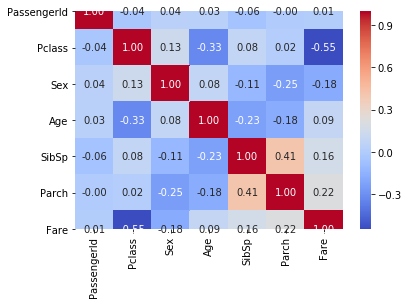

In [169]:
corr = df_train.corr()
plt.autoscale()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

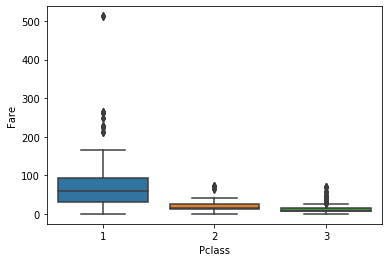

In [170]:
sns.boxplot(data = df_train, x = 'Pclass', y = 'Fare')

In [171]:
# Count of passengers per class

df_train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

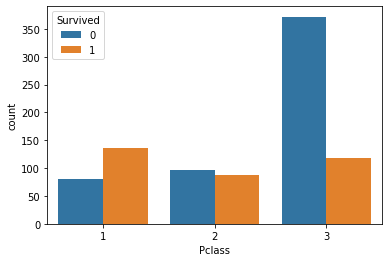

In [172]:
sns.countplot(df_train['Pclass'], hue = df_train['Survived'])

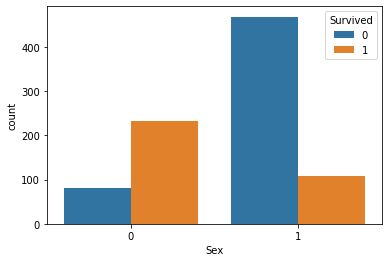

In [173]:
sns.countplot(df_train['Sex'], hue = df_train['Survived']) # Female=0, Male=1

In [174]:
df_train["Survived"].value_counts(normalize=True)*100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

In [175]:
# I dropped following variables- PassengerId, Name, Ticket, Cabin, Embarked 
# because id, name, ticket number, cabin number and port from where passengers embarked
# cannot provide valuable information about survival

predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
outcome ='Survived'

X = df_train[predictors]
y = df_train[outcome]

# Split validation
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y= train_test_split(X,y, test_size=0.20, random_state=1)

# Modelling
I test with 4 models to find the best model for prediction:

1. Decision Tree Classifier

2. Logistic Regression

3. Naive Bayes

4. Random Forest Classifier

# Decision Tree Classifier

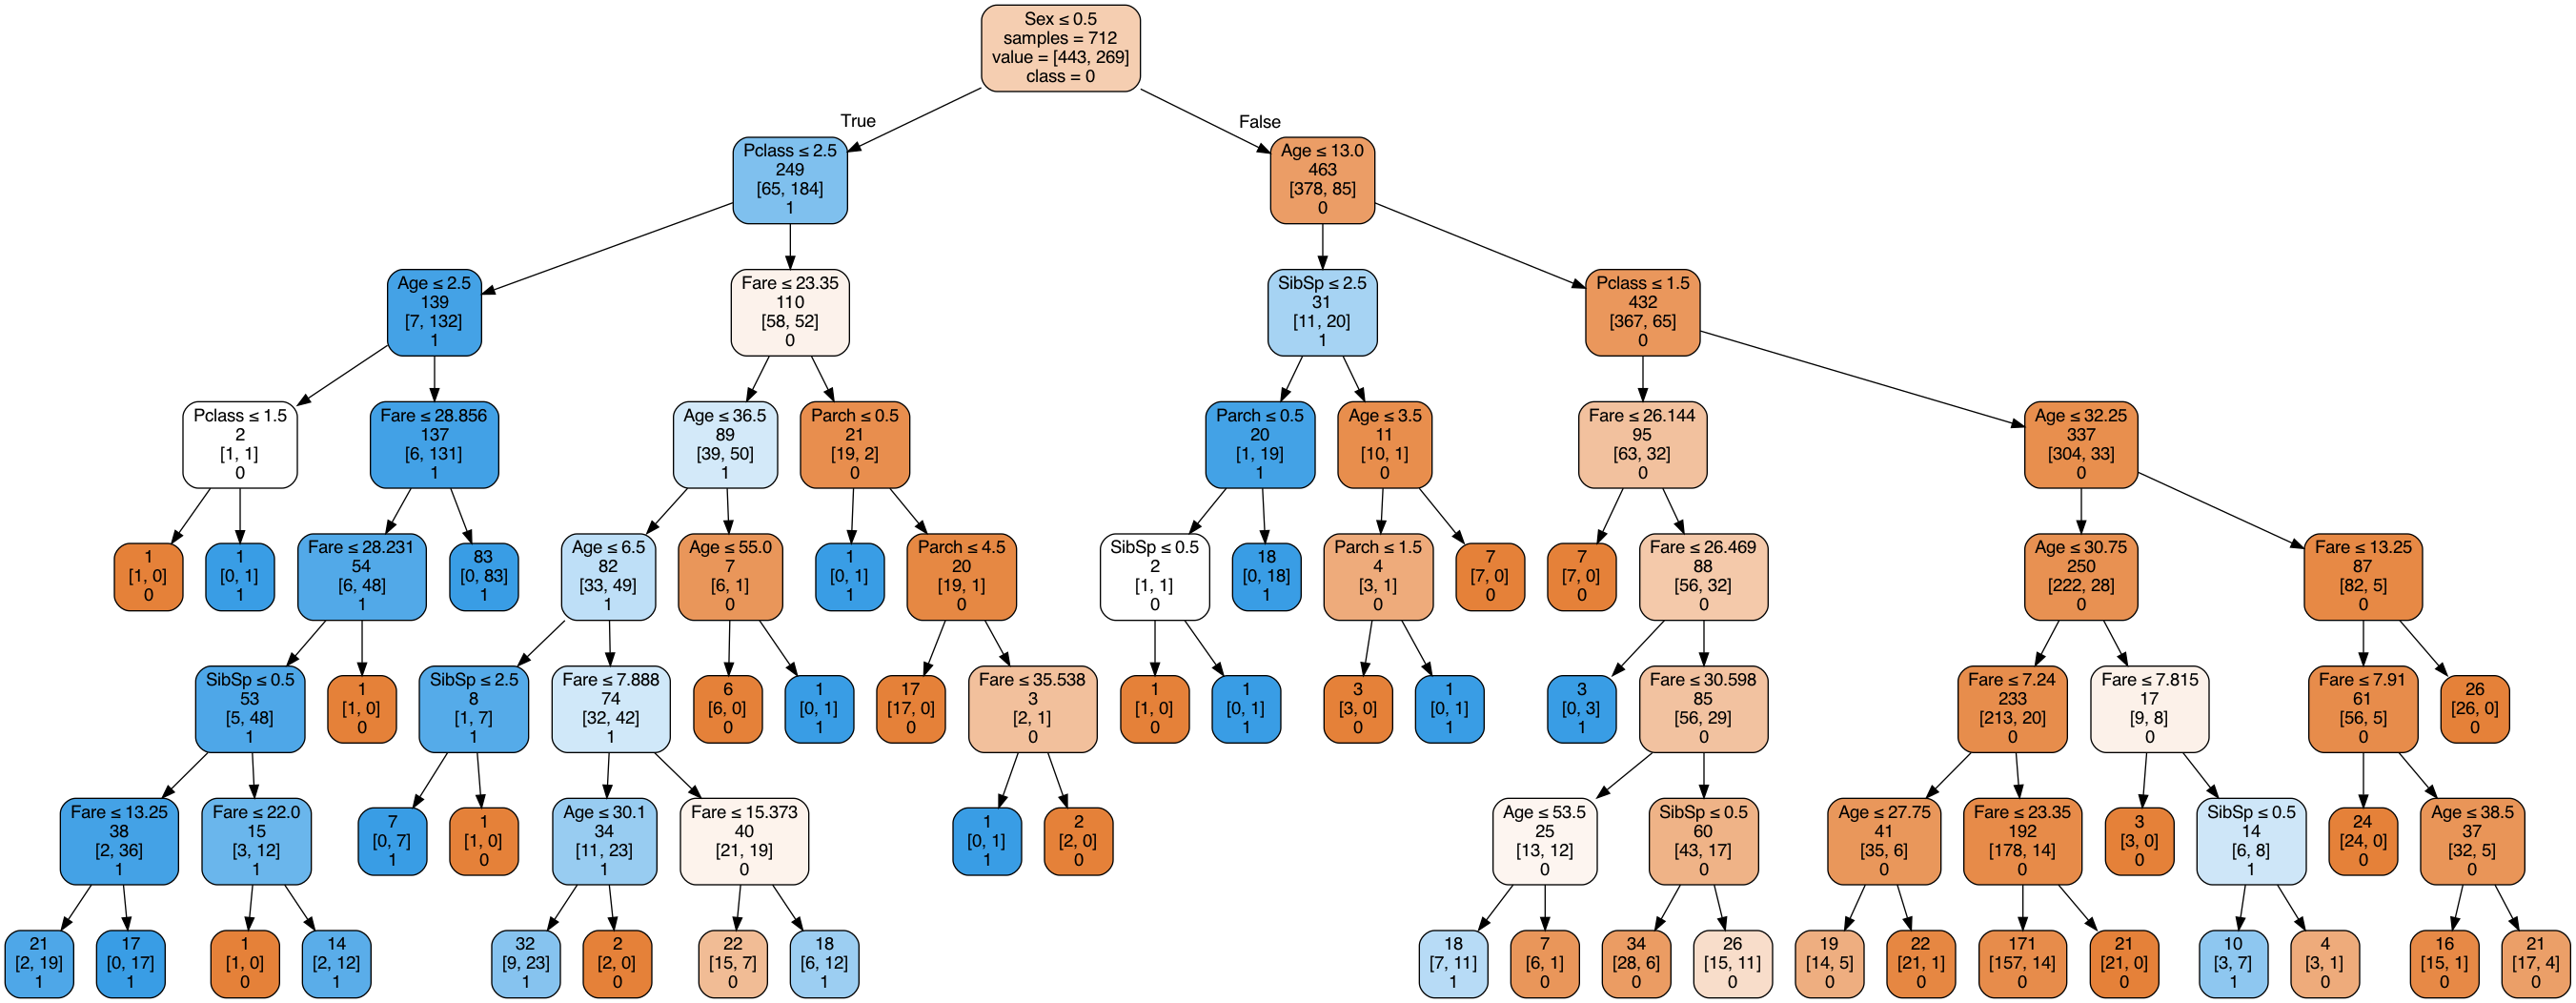

In [176]:
dt = DecisionTreeClassifier(max_depth = 7)
dt.fit(train_X, train_y)
plotDecisionTree(dt, feature_names=train_X.columns, class_names=dt.classes_)

In [177]:
importances = dt.feature_importances_
df_imp = pd.DataFrame({'feature': train_X.columns, 'importance': importances})
df_imp = df_imp.sort_values('importance', ascending = False)
print(df_imp)

  feature  importance
1     Sex    0.463870
0  Pclass    0.173659
2     Age    0.146453
5    Fare    0.116972
3   SibSp    0.077285
4   Parch    0.021761


In [178]:
# Model evaluation on training set
print("Accuracy with training set:",accuracy_score(train_y, dt.predict(train_X)))
# Model evaluation on validation set
print("Accuracy with validation set:",accuracy_score(valid_y, dt.predict(valid_X)))
print(" ")
print("precision score: ", precision_score(valid_y,dt.predict(valid_X)))
print("recall score: ", recall_score(valid_y,dt.predict(valid_X)))
print("f1-score: ", f1_score(valid_y,dt.predict(valid_X)))

Accuracy with training set: 0.8876404494382022
Accuracy with validation set: 0.770949720670391
 
precision score:  0.7857142857142857
recall score:  0.6027397260273972
f1-score:  0.6821705426356588


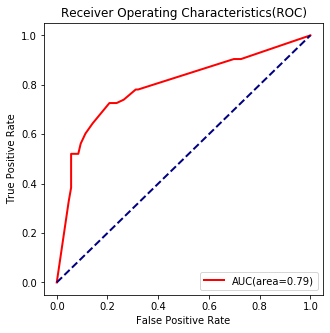

In [179]:
from sklearn.metrics import auc, roc_curve

# Creating a function for ROC graph plotting to be used by other models
def roc_graph(clf, valid_y, valid_X):
    fpr,tpr,_=roc_curve(valid_y,clf.predict_proba(valid_X)[:,1])
    area=auc(fpr,tpr)
    
    plt.figure(figsize=[5,5])
    plt.plot(fpr,tpr, color="red",lw=2, label="AUC(area=%.2f)" % area)
    plt.plot([0,1],[0,1],color="navy",linestyle="--",lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristics(ROC)")
    plt.legend(loc="lower right")
    plt.show()
    
# Calling the function with Decision tree classifier inputs
roc_graph(dt, valid_y, valid_X)

# Logistic Regression

In [180]:
logit = LogisticRegression(penalty="l2", solver='liblinear')
logit.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [181]:
# Model evaluation on training set
print("Accuracy with training set:",accuracy_score(train_y, logit.predict(train_X)))
# Model evaluation on validation set
print("Accuracy with validation set:",accuracy_score(valid_y, logit.predict(valid_X)))
print(" ")
print("precision score: ", precision_score(valid_y,logit.predict(valid_X)))
print("recall score: ", recall_score(valid_y,logit.predict(valid_X)))
print("f1-score: ", f1_score(valid_y,logit.predict(valid_X)))

Accuracy with training set: 0.7963483146067416
Accuracy with validation set: 0.7988826815642458
 
precision score:  0.8032786885245902
recall score:  0.6712328767123288
f1-score:  0.7313432835820896


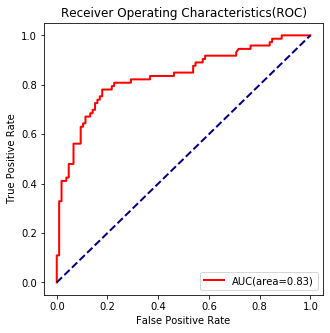

In [182]:
# Calling the function with Decision tree classifier inputs
roc_graph(logit, valid_y, valid_X)

# Naive Bayes

In [183]:
# run naive Bayes
nb = GaussianNB()
nb.fit(train_X,train_y)

# predict class membership
prediction_train_nb=nb.predict(valid_X)

# predict probabilities
pred_train_prob_nb = nb.predict_proba(valid_X)

In [184]:
# Model evaluation on training set
print("Accuracy with training set:",accuracy_score(train_y, nb.predict(train_X)))
# Model evaluation on validation set
print("Accuracy with validation set:",accuracy_score(valid_y, nb.predict(valid_X)))
print(" ")
print("precision score: ", precision_score(valid_y,nb.predict(valid_X)))
print("recall score: ", recall_score(valid_y,nb.predict(valid_X)))
print("f1-score: ", f1_score(valid_y,nb.predict(valid_X)))

Accuracy with training set: 0.7949438202247191
Accuracy with validation set: 0.7597765363128491
 
precision score:  0.734375
recall score:  0.6438356164383562
f1-score:  0.6861313868613139


# Random Forest

In [185]:
rf=RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [186]:
# Model evaluation on training set
print("Accuracy with training set:",accuracy_score(train_y, rf.predict(train_X)))
# Model evaluation on validation set
print("Accuracy with validation set:",accuracy_score(valid_y, rf.predict(valid_X)))
print(" ")
print("precision score: ", precision_score(valid_y,rf.predict(valid_X)))
print("recall score: ", recall_score(valid_y,rf.predict(valid_X)))
print("f1-score: ", f1_score(valid_y,rf.predict(valid_X)))

Accuracy with training set: 0.9873595505617978
Accuracy with validation set: 0.7988826815642458
 
precision score:  0.8490566037735849
recall score:  0.6164383561643836
f1-score:  0.7142857142857144


### Logistic Regression model shows best accuracy and highest Senstivity(Recall).That means there are less number of False negatives(people classified as dead but actually survived). The performance gap between the training and test sets is also minimal. 

# Predictions on Test set using Logistic Regression 

In [187]:
df_test=pd.read_csv("test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [188]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [189]:
# Test Data Preprocessing

In [190]:
# Dummy code the variable sex.
df_test['Sex'] = pd.get_dummies(df_test['Sex'], prefix_sep='_', drop_first=True)

# filling the missing ages with mean ages
df_test['Age'].fillna((df_test['Age'].mean()), inplace=True)
df_test['Fare'].fillna((df_test['Fare'].mean()), inplace=True)
df_test.shape

(418, 11)

In [191]:
test_predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

X_test = df_test[predictors]
df_test["Survived"]= logit.predict(X_test)
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,S,1


In [192]:
df_test["Survived"].value_counts(normalize=True)*100

0    64.114833
1    35.885167
Name: Survived, dtype: float64

In [193]:

import plotly.graph_objects as go
fig = go.Figure()
labels=["Died","Survived"]
fig.add_trace(go.Pie(labels=labels, values=df_test['Survived'].value_counts()))
fig.update_layout(autosize=False, width=400, height=350)
fig.show()

In [194]:
df=df_test[["PassengerId","Survived"]]
df=df.set_index("PassengerId")
df.to_csv("Titanic_output_Ridhi.csv")
out=pd.read_csv("Titanic_output_Ridhi.csv")
out

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
